In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.atmosphere import gueymard94_pw

In [2]:
# Importing the dataset
weather_data_path = 'weather/'
solar_data_path = 'solar/'

weather_data = pd.read_csv(weather_data_path+'Data_kota_separat.csv')
weather_data.rename(columns={'Unnamed: 0':'Timestamp'}, inplace=True)
solar_data = pd.read_csv(solar_data_path + 'solar.csv')
def approximate(x):
    return x[:-4]+'00'
solar_data['Time'] = solar_data.Time.apply(lambda x : approximate(x))
weather_data = weather_data.loc[weather_data['Timestamp'].isin(solar_data['Time'])]

In [3]:
solar_data['Time'] = pd.to_datetime(solar_data['Time'].values, format='%Y-%m-%d %H:%M:%S')
solar_data.set_index(solar_data['Time'], inplace=True)
solar_data.drop('Time', inplace=True, axis=1)
solar_data.index = solar_data.index.tz_localize('Asia/Kolkata')
solar_data.head()

,Vpv1,Vpv2,Ipv1,Ipv2,Vac1,Vac2,Vac3,Iac1,Iac2,Iac3,Pac,Fac,E-Total,H-Total,E-Today,Temp
Time,,,,,,,,,,,,,,,,
2018-05-06 12:46:00+05:30,496.7,0.0,7.4,0.0,243.3,222.9,239.4,5.0,5.0,5.0,3654.0,49.93,454.4,240.0,13.1,54.2
2018-05-06 12:51:00+05:30,489.0,0.0,7.6,0.0,242.3,224.9,240.4,5.2,5.1,5.2,3600.0,49.96,454.8,240.0,13.5,54.4
2018-05-06 12:56:00+05:30,497.4,0.0,7.5,0.0,245.1,221.4,240.6,5.2,5.0,5.1,3648.0,50.03,455.1,241.0,13.8,54.6
2018-05-06 13:01:00+05:30,490.6,0.0,7.4,0.0,244.0,224.5,241.5,5.0,5.0,5.0,3659.0,50.10,455.4,241.0,14.1,54.8
2018-05-06 13:06:00+05:30,490.6,0.0,7.4,0.0,242.7,222.8,239.2,5.1,5.1,5.0,3585.0,50.05,455.7,241.0,14.4,54.9


In [4]:
# reduce the weather data and keep only the entries for which the solar data is available
if 'Timestamp' in weather_data.columns:
    weather_data.reset_index(drop=True, inplace=True)
    weather_data['Timestamp'] = pd.to_datetime(weather_data['Timestamp'].values, format='%Y-%m-%d %H:%M:%S')
    weather_data.set_index(weather_data['Timestamp'], inplace=True)
    weather_data.drop('Timestamp', inplace=True, axis=1)
weather_data.head()

,Battery Level (V),relative_humidity,air_temp,wind_speed,Wind Direction (°),Dew Point (°C),Global Radiation 1 (W/m2),Diffuse Radiation (W/m2),Atmospheric Pressure QNH (mb),Atmospheric Pressure QFE (mb),Direct Radiation 1 (W/m2),Solar Azimuth (°),Global Energy 1 (kWh/m2),Diffuse Energy 1 (kWh/m2),Direct Energy 1 (kWh/m2),Global Energy 1 (MJ/m2),Diffuse Energy 1 (MJ/m2),Direct Energy 1 (MJ/m2)
Timestamp,,,,,,,,,,,,,,,,,,
2018-05-06 12:46:00,13.5435,11.53090,41.2083,0.481642,194.469,5.90070,909.660,264.500,1006.04,970.171,673.202,237.250,0.015153,0.004405,0.011201,0.054549,0.015857,0.040325
2018-05-06 12:51:00,13.5484,9.95614,41.9842,3.144320,240.983,4.41924,908.991,267.461,1005.91,970.043,673.282,239.931,0.015158,0.004453,0.011250,0.054569,0.016032,0.040499
2018-05-06 12:56:00,13.5467,9.41877,42.1846,1.600240,180.964,3.80964,890.220,267.483,1005.70,969.843,656.265,242.329,0.014871,0.004459,0.010964,0.053534,0.016054,0.039472
2018-05-06 13:01:00,13.5466,10.04090,41.8025,1.441300,238.379,4.41003,901.187,267.491,1005.70,969.839,673.950,244.478,0.014993,0.004456,0.011183,0.053973,0.016042,0.040258
2018-05-06 13:06:00,13.5512,9.48973,42.1796,1.618480,181.860,3.91016,888.130,273.098,1005.57,969.719,656.922,246.435,0.014824,0.004549,0.010958,0.053366,0.016377,0.039450


In [5]:
weather_data.index = weather_data.index.tz_localize('Asia/Kolkata')
# Drop rows which have null temp and humidity values
weather_data.dropna(subset=['relative_humidity','air_temp'], inplace=True)
# Drop invalid values such as temp below 0 deg C or above 48 deg C
weather_data = weather_data[(weather_data['air_temp'] > 0.0) & (weather_data['air_temp'] < 45.0)]
# Add a precipitable water predicted column to weather_data
weather_data['precipitable_water'] = gueymard94_pw(weather_data['air_temp'], weather_data['relative_humidity'])
weather_data.head()

,Battery Level (V),relative_humidity,air_temp,wind_speed,Wind Direction (°),Dew Point (°C),Global Radiation 1 (W/m2),Diffuse Radiation (W/m2),Atmospheric Pressure QNH (mb),Atmospheric Pressure QFE (mb),Direct Radiation 1 (W/m2),Solar Azimuth (°),Global Energy 1 (kWh/m2),Diffuse Energy 1 (kWh/m2),Direct Energy 1 (kWh/m2),Global Energy 1 (MJ/m2),Diffuse Energy 1 (MJ/m2),Direct Energy 1 (MJ/m2),precipitable_water
Timestamp,,,,,,,,,,,,,,,,,,,
2018-05-06 12:46:00+05:30,13.5435,11.53090,41.2083,0.481642,194.469,5.90070,909.660,264.500,1006.04,970.171,673.202,237.250,0.015153,0.004405,0.011201,0.054549,0.015857,0.040325,1.411996
2018-05-06 12:51:00+05:30,13.5484,9.95614,41.9842,3.144320,240.983,4.41924,908.991,267.461,1005.91,970.043,673.282,239.931,0.015158,0.004453,0.011250,0.054569,0.016032,0.040499,1.269299
2018-05-06 12:56:00+05:30,13.5467,9.41877,42.1846,1.600240,180.964,3.80964,890.220,267.483,1005.70,969.843,656.265,242.329,0.014871,0.004459,0.010964,0.053534,0.016054,0.039472,1.213312
2018-05-06 13:01:00+05:30,13.5466,10.04090,41.8025,1.441300,238.379,4.41003,901.187,267.491,1005.70,969.839,673.950,244.478,0.014993,0.004456,0.011183,0.053973,0.016042,0.040258,1.268106
2018-05-06 13:06:00+05:30,13.5512,9.48973,42.1796,1.618480,181.860,3.91016,888.130,273.098,1005.57,969.719,656.922,246.435,0.014824,0.004549,0.010958,0.053366,0.016377,0.039450,1.222136


### Plant Information

- Panel : Vikram Solar Eldora VSP.72.315.03, 16 panels X 315Wp
- Tilt : 25 degree south-facing
- Inverter : Zever Solar
- Capacity : 5kW
- Lats, Longs : 25.1, 75.8
- Elevation  : 249m

In [6]:
lats, longs = 25.20, 75.88
tilt = 25
surf_azi = 180 #since panel faces south
altitude = 249
panel_model = retrieve_sam('CECMod')
panel_model = panel_model['Vikram_Solar_Eldora_VSP_72_315_03']
inverter_model = retrieve_sam('CECinverter')
inverter_model = inverter_model['Power_One__PVI_3_8_OUTD_S_US_Z_A__240V__240V__CEC_2018_']

In [7]:
location = Location(latitude=lats, longitude=longs, altitude=altitude)
system = PVSystem(surface_tilt = tilt, surface_azimuth=surf_azi, albedo=0.40, 
                  module_parameters=panel_model, inverter_parameters=inverter_model,
                 modules_per_string=16, strings_per_inverter=1, name='Kota_system')
mc = ModelChain(system, location, aoi_model='no_loss', name='Kota_ModelChain')

In [8]:
mc.run_model(times = weather_data.index, weather = weather_data)

/home/limosin/miniconda3/envs/solarpv/lib/python3.7/site-packages/pvlib/atmosphere.py:447: UserWarning: Exceptionally high Pwat values. Check input data: model may diverge in this range
  warn('Exceptionally high Pwat values. Check input data:' +
/home/limosin/miniconda3/envs/solarpv/lib/python3.7/site-packages/pvlib/atmosphere.py:454: RuntimeWarning: invalid value encountered in minimum
  airmass_absolute = np.minimum(airmass_absolute, 10)
/home/limosin/miniconda3/envs/solarpv/lib/python3.7/site-packages/pvlib/singlediode.py:424: RuntimeWarning: invalid value encountered in greater
  idx_p = 0. < Gsh
/home/limosin/miniconda3/envs/solarpv/lib/python3.7/site-packages/pvlib/tools.py:411: RuntimeWarning: invalid value encountered in greater
  df['SW_Flag'] = df['f1'] > df['f2']
/home/limosin/miniconda3/envs/solarpv/lib/python3.7/site-packages/pvlib/tools.py:418: RuntimeWarning: invalid value encountered in greater
  errflag = (abs(err) > .01).any()


ModelChain: 
  name: Kota_ModelChain
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: snlinverter
  aoi_model: no_aoi_loss
  spectral_model: first_solar_spectral_loss
  temp_model: sapm_temp
  losses_model: no_extra_losses

In [9]:
output = mc.dc
output = output.loc[solar_data.index]
output.head()

/home/limosin/miniconda3/envs/solarpv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


,i_sc,v_oc,i_mp,v_mp,p_mp,i_x,i_xx
Time,,,,,,,
2018-05-06 12:46:00+05:30,8.470978,661.621275,7.795779,538.635181,4199.080962,8.365133,5.770460
2018-05-06 12:51:00+05:30,8.417863,673.286774,7.760377,550.515937,4272.211293,8.310896,5.764792
2018-05-06 12:56:00+05:30,8.395905,666.954684,7.735209,544.092035,4208.665411,8.290198,5.740439
2018-05-06 13:01:00+05:30,8.369512,666.467477,7.710457,543.694578,4192.133893,8.264213,5.722751
2018-05-06 13:06:00+05:30,8.327772,667.444538,7.673024,544.836412,4180.543123,8.222853,5.698338


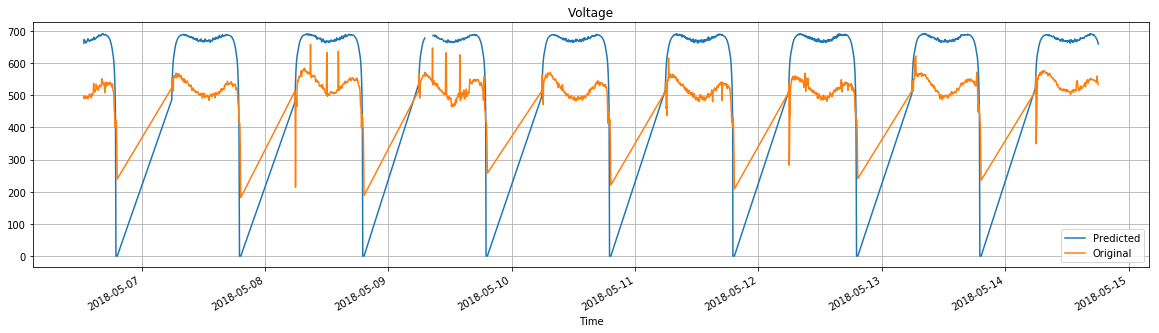

In [10]:
plt.figure(figsize=[20,5])
output.v_oc[0:1500].plot(grid=True, label='Predicted')
solar_data.Vpv1[0:1500].plot(grid=True, label='Original')
plt.title('Voltage')
plt.legend()
plt.savefig(fname='predictions_voltage')

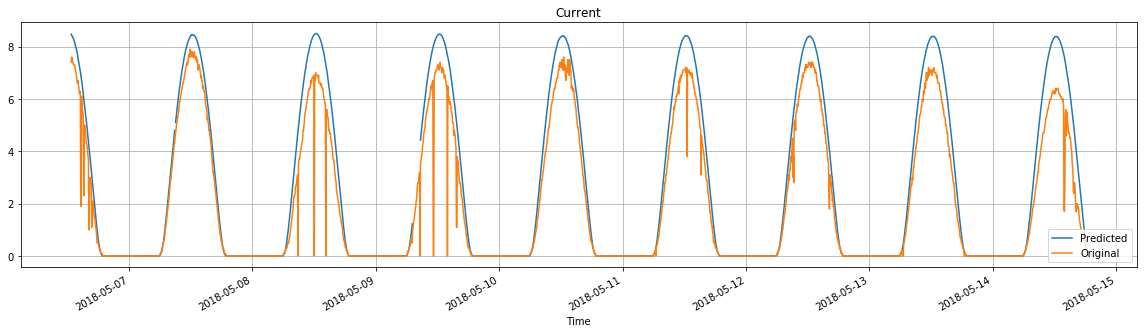

In [11]:
plt.figure(figsize=[20,5])
output.i_sc[0:1500].plot(grid=True, label='Predicted')
solar_data.Ipv1[0:1500].plot(grid=True, label='Original')
plt.title('Current')
plt.legend()
plt.savefig(fname='predictions_current')

In [12]:
Power_pred = output['i_sc']*output['v_oc']
Power_orig_ac = solar_data['Pac']
Power_orig_dc = solar_data['Vpv1']*solar_data['Ipv1']

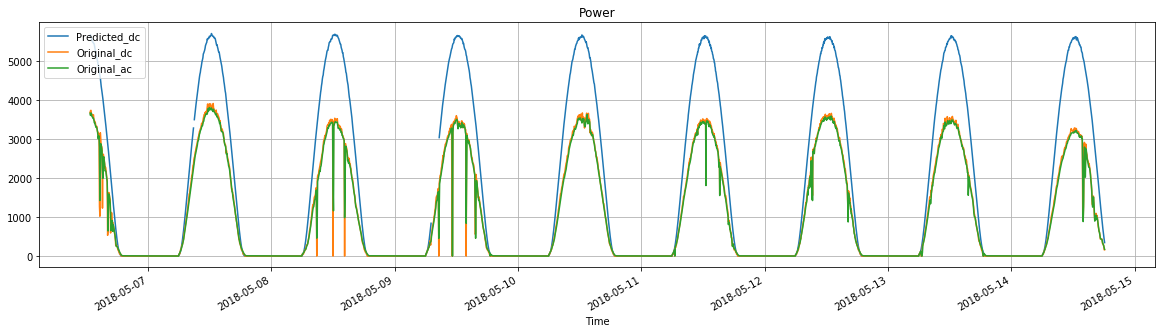

In [13]:
plt.figure(figsize=[20,5])
Power_pred[0:1500].plot(grid=True, label='Predicted_dc')
Power_orig_dc[0:1500].plot(grid=True, label='Original_dc')
Power_orig_ac[0:1500].plot(grid=True, label='Original_ac')
plt.title('Power')
plt.legend()
plt.savefig(fname='predictions_power')